# MODEL AND SCORING IMPLEMENTATION

# 1. Calculation of Scoring

The scoring $S_{ijk}$ is a value that multiplies each variable $X_{ijk}$ in order to increase or decrease the probability of being included in the model.

>$S_{ijk}$: scoring applied to vehicle type $i$ at station $j$ and during shift $k$. Each value of $S_{ijk}$ is calculated as follows:

$S_{ijk} = P_{NearbyNeighborhoods_j}*S_{NearbyNeighborhoods_j} + P_{Density_j}*S_{Density_j} + P_{Capacity_j}*S_{Capacity_j} + P_{NearbyStations_j}*S_{NearbyStations_j} + P_{ShiftIncidents_k}*S_{ShiftIncidents_k} + P_{Vehicle_{i,k}}*S_{Vehicle_{i,k}}$.

$S_{ijk} \geq{0};\ S_{ijk} \in \mathbb{R} ;\ S_{ijk} \in [0,1]$

---

Where $P_{x}$ is the weight associated with each scoring $S_{x}$. The values of $P_{x}$ are in the range of `[0,1]`. These weights will be as follows:

- $P_{NearbyNeighborhoods_j} = 0.25$
- $P_{Density_j} = 0.05$
- $P_{Capacity_j} = 0.15$
- $P_{NearbyStations_j} = 0.2$
- $P_{ShiftIncidents_k} = 0.25$
- $P_{Vehicle_{i,k}} = 0.1$

Where $\Sigma_{x=1}^6 P_{x}=1, x \in \{NearbyNeighborhoods_j, Density_j, Capacity_j, NearbyStations_j, ShiftIncidents_k, Vehicle_{i,k}\}$

---

On the other hand, the application with the model variables, would be as follows:

$maxZ = S_{1,1,1}*X_{1,1,1} + S_{2,1,1}*X_{2,1,1} + S_{3,1,1}*X_{3,1,1} + S_{4,1,1}*X_{4,1,1} + S_{5,1,1}*X_{5,1,1} + S_{1,1,2}*X_{1,1,2} + S_{2,1,2}*X_{2,1,2} + S_{3,1,2}*X_{3,1,2} + S_{4,1,2}*X_{4,1,2} + S_{5,1,2}*X_{5,1,2} + ... + S_{5,218,2}*X_{5,218,2} $

In this way, we would have 10 different scorings for each station, 5 for each shift, each one for a type of vehicle per shift.


## 1.1 Scoring Libraries

In [1]:
import json
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1.2 Scoring Functions

In [2]:
def load_json(lista_urls):
    """Load the json from the URL.
    - list_urls (list): list of URLs with the json to download.
    Returns a list with the generated json.
    """
    return (json.loads(requests.get(url).text) for url in lista_urls)

def create_dic_density(neighborhoods):
    """Create a dictionary with densities of all neighborhoods.
    - neighborhoods (json): json of neighborhoods.
    Returns a dictionary with neighborhood id as the key and density as the value.
    """
    dic_density = {} # density dictionary
    for b in neighborhoods:
        dic_density[b['nta']] = round( (b['population'] / b['shape_area'])*100 , 5)
    return dic_density

def create_dic_incid(incidents):
    """Calculate a dictionary of incidents by neighborhood.
    - incidents (json): json of incidents.
    Returns a dictionary of incidents.
    """
    dic_incid = {} # incidents dictionary.
    for i in incidents:
        barri = i['nta'] # "Neighborhood of the incident"
        if barri not in dic_incid:
            dic_incid[barri] = {} # dict within each Neighborhood
            # count of indicidents in each Neighborhood
            dic_incid[barri]['noche'] = {'num_incid': 0}
            dic_incid[barri]['dia'] = {'num_incid': 0}
        turno = 'noche' # night
        if i['is_first_shift'] == False: # day
            turno = 'dia'

        dic_incid[barri][turno]['num_incid'] += 1 # increase the counter

        incid_pos = dic_incid[barri][turno]['num_incid']
        # take the incident value and use it to create a list of vehicle types
        # each position in the list represents a type of vehicle.
        dic_incid[barri][turno][f'incidente_{incid_pos}'] = [0,0,0,0,0]

        units = i['units'] # store types of vehicle involved in the incident
        for u in set(units): # use set to get unique values
            # store values for each type of vehicle per incident
            if u == 'engine':
              dic_incid[barri][turno][f'incidente_{incid_pos}'][0] += units.count(u)
            elif u == 'ladder':
              dic_incid[barri][turno][f'incidente_{incid_pos}'][1] += units.count(u)
            elif u == 'rescue':
              dic_incid[barri][turno][f'incidente_{incid_pos}'][2] += units.count(u)
            elif u == 'squad':
              dic_incid[barri][turno][f'incidente_{incid_pos}'][3] += units.count(u)
            elif u == 'hazardous':
              dic_incid[barri][turno][f'incidente_{incid_pos}'][4] += units.count(u)
    return dic_incid

def create_dic_stations(stations, dist_est_barrios, dic_density, dic_incid, dist_est):
    """Calculate the scores of each type for each of the stations.
    - stations (json): json of stations.
    - dist_est_barrios (json): json of distances from stations to neighborhoods.
    - dic_density (dict): precalculated dictionary of densities by neighborhood.
    - dic_incid (dict): precalculated dictionary of incidents by neighborhood.
    - dist_est (json): json of distances between stations.
    Returns each of the scores (8), the dictionary of stations, and a list
    with the names of each station.
    """
    dic_ests  = {} # stations dictionary
    n_est = [] # names of stations
    bc, dens, i_noc, i_dia, v_noc, v_dia, caps, ec = [],[],[],[],[],[],[],[]

    for i in stations:
        ### STATION NAME
        dir = i['address']
        dic_ests[dir] = {}

        n_est.append(dir)

        ### NEARBY NEIGHBORHOODS (<= 780 segs)
        dic_ests[dir]['barrios_cercanos'] = {}
        for b,d in dist_est_barrios[dir].items():
            if d <= 780: # Less than this distance, some neighborhoods are not included
                dic_ests[dir]['barrios_cercanos'][b] = [d]

        bc.append(len(dic_ests[dir]['barrios_cercanos']))

        ### STATION NEIGHBORHOOD WITH NAME, DISTANCE AND DENSITY
        dist, barrio = min((v[0],k) for k,v in dic_ests[dir]['barrios_cercanos'].items())
        dic_ests[dir]['barrio'] = [barrio, dist, dic_density[barrio]]

        dens.append(dic_density[barrio])

        ### INCIDENTS IN NEARBY NEIGHBORHOODS
        for b,d in dic_ests[dir]['barrios_cercanos'].items():
            if b in dic_incid.keys():
              d.append(dic_incid[b])
            else:
              d.append({})

        ### MAXIMUM DAYTIME AND NIGHTTIME INDICENTS IN A NEIGHBORHOOD
        incid_mean_noche, incid_mean_dia = [],[]
        for b,d in dic_ests[dir]['barrios_cercanos'].items():
          if d[1] != {}:
              if d[1]['noche'] != {}: # nighttime
                  incid_mean_noche.append((d[1]['noche']['num_incid'], b))
              else:
                  incid_mean_noche.append((0, b))
              if d[1]['dia'] != {}: # daytime
                  incid_mean_dia.append((d[1]['dia']['num_incid'], b))
              else:
                  incid_mean_dia.append((0, b))
          else:
              incid_mean_noche.append((0, b))
              incid_mean_dia.append((0, b))

        incid_mean_noche = int(np.mean([x[0] for x in incid_mean_noche]))
        incid_mean_dia = int(np.mean([x[0] for x in incid_mean_dia]))

        dic_ests[dir]['incidentes_max'] = {'noche': incid_mean_noche,
                                          'dia': incid_mean_dia }

        i_noc.append(incid_mean_noche)
        i_dia.append(incid_mean_dia)

        ### KIND OF VEHICLES BY INCIDENTS
        for b,d in dic_ests[dir]['barrios_cercanos'].items():
          if d[1] != {}:
              mean_vh_noche = np.mean(np.array([ v if (k != 'num_incid' and d[1]['noche'] is not None) else [0,0,0,0,0]
                                                          for k,v in d[1]['noche'].items() ]), axis=0)
              mean_vh_dia = np.mean(np.array([ v if (k != 'num_incid' and d[1]['dia'] is not None) else [0,0,0,0,0]
                                                          for k,v in d[1]['dia'].items() ]), axis=0)
          else:
              continue
          dic_ests[dir]['media_tipo_vhs'] = {
                  'noche': list(mean_vh_noche),
                  'dia': list(mean_vh_dia)
              }

        v_noc.append(list(mean_vh_noche))
        v_dia.append(list(mean_vh_dia))

        ### STATION CAPACITY
        dic_ests[dir]['capacidad'] = i['capacity']

        caps.append(dic_ests[dir]['capacidad'])

        ### NEARBY STATIONS (<= 700 seg)
        dic_ests[dir]['estaciones_cercanas'] = []
        for e,d in dist_est[dir].items():
            if d <= 700: # Less than this distance, some neighborhoods are not included
                dic_ests[dir]['estaciones_cercanas'].append((e,d))

        ec.append(len(dic_ests[dir]['estaciones_cercanas']))

    return bc, dens, i_noc, i_dia, caps, ec, v_noc, v_dia, dic_ests, n_est

### NORMALIZE SCORES FOR UNIQUE VALUES
def normalize_list(numbers):
    """Applies a min-max normalization to the single-value scores.
    - numbers (list): list of scores for each station with unique values
    Returns the list of normalized scores.
    """
    min_val = min(numbers)
    max_val = max(numbers)
    normalized = [(x - min_val) / (max_val - min_val) for x in numbers]
    return normalized

### INVERSE NORMALIZATION OF SCORES FOR UNIQUE VALUES (nearby stations and capacity)
def normalize_list_invers(numbers):
    """Applies a min-max normalization to single-value scores that have
    an inverse relationship (nearby stations and capacity).
    - numbers (list): list of scores for each station with unique values
    Returns the list of normalized scores.
    """
    min_val = min(numbers)
    max_val = max(numbers)
    normalized = [1-((x - min_val) / (max_val - min_val)) for x in numbers]
    return normalized

### NORMALIZE SCORES FOR VALUES IN LISTS (kind of vehicle)
def normalize_list_of_lists(list_of_lists):
    """Applies a min-max normalization to the grouped scores.
    - list_of_lists (list): list of lists of scores with grouped values,
    which in this case are the types of vehicles. Each list of lists has
    5 values.
    Returns a list of lists with the normalized scores.
    """
    normalized_list_of_lists = []
    for sublist in list_of_lists:
        if all(sublist) == False:
            normalized_sublist = [0.2]*5
        else:
            min_val = min(sublist)
            max_val = max(sublist)
            normalized_sublist = [1-((x - min_val) / (max_val - min_val)) for x in sublist]
        normalized_list_of_lists.append(normalized_sublist)
    return normalized_list_of_lists

### GENERATE A LIST OF NORMALIZED SCORES AND SORT IT
def scores_norm(l_scores_1, l_scores_2):
    """Combines the two types of scores into a single list.
    - l_scores_1 (list): list of normalized single-value scores.
    - l_scores_2 (list): list of lists of normalized grouped scores.
    Returns a list with all the normalized scores.
    """
    list_scores_norm = []
    for i,l in enumerate(l_scores_1):
        if i == 4 or i == 5:
            list_scores_norm.append(normalize_list_invers(l))
        else:
            list_scores_norm.append(normalize_list(l))
    for l in l_scores_2:
        list_scores_norm.append(normalize_list_of_lists(l))
    return list_scores_norm

### ADD SCORES TO EACH STATION
def add_scores_to_station(n_est, dic_estaciones, list_scores_norm):
    """Adds the scorings to the stations dictionary, creating a structure
    suitable for the next process.
    - n_est (list): list of station names.
    - dic_estaciones (dict): stations dictionary.
    - list_scores_norm (list): list of normalized scores
    Returns the stations dictionary with the scorings for each station.
    """
    dic_ests = dic_estaciones.copy()
    for e in range(len(n_est)):
        dic_ests[n_est[e]]['scorings'] = {
            'num_barrios_cerca': list_scores_norm[0][e],
            'densidad': list_scores_norm[1][e],
            'mean_incids_noche': list_scores_norm[2][e],
            'mean_incids_dia': list_scores_norm[3][e],
            'capacidad': list_scores_norm[4][e],
            'num_estaciones_cerca': list_scores_norm[5][e],
            'vhs_1_noche': list_scores_norm[6][e][0],
            'vhs_2_noche': list_scores_norm[6][e][1],
            'vhs_3_noche': list_scores_norm[6][e][2],
            'vhs_4_noche': list_scores_norm[6][e][3],
            'vhs_5_noche': list_scores_norm[6][e][4],
            'vhs_1_dia': list_scores_norm[7][e][0],
            'vhs_2_dia': list_scores_norm[7][e][1],
            'vhs_3_dia': list_scores_norm[7][e][2],
            'vhs_4_dia': list_scores_norm[7][e][3],
            'vhs_5_dia': list_scores_norm[7][e][4]
        }
    return dic_ests

def calculate_general_scoring(dic_ests, importancias):
    """Multiplies each score by its associated importance and sums up the values,
    generating the 10 corresponding scores for each station: 5 for the day shift
    and 5 for the night shift.
    - dic_ests (dict): dictionary of stations with the scorings included.
    - importancias (dict): dictionary with the importances for each type of scoring.
    Returns a dictionary with the resulting scorings unnormalized.
    """
    resultados = {}
    for nombre, datos in dic_ests.items():
        scorings = datos['scorings']
        scoring_noche = []

        for i in range(5):
          # Nighttime Scoring
            s_noche = (
                scorings['num_barrios_cerca'] * importancias['num_barrios_cerca'] +
                scorings['densidad'] * importancias['densidad'] +
                scorings['mean_incids_noche'] * importancias['mean_incids_noche'] +
                scorings['capacidad'] * importancias['capacidad'] +
                scorings['num_estaciones_cerca'] * importancias['num_estaciones_cerca'] +
                scorings[f'vhs_{i+1}_noche'] * importancias[f'vhs_{i+1}_noche']
            )
            scoring_noche.append(s_noche)

        scoring_dia = []

        # Daytime Scoring
        for i in range(5):
            s_dia = (
                scorings['num_barrios_cerca'] * importancias['num_barrios_cerca'] +
                scorings['densidad'] * importancias['densidad'] +
                scorings['mean_incids_dia'] * importancias['mean_incids_dia'] +
                scorings['capacidad'] * importancias['capacidad'] +
                scorings['num_estaciones_cerca'] * importancias['num_estaciones_cerca'] +
                scorings[f'vhs_{i+1}_dia'] * importancias[f'vhs_{i+1}_dia']
            )
            scoring_dia.append(s_dia)

        resultados[nombre] = {'scoring_noche': scoring_noche, 'scoring_dia': scoring_dia}
    return resultados

def mix_max_scores(results):
    """Calculates the minimums and maximums of the scorings for all stations.
    - results (dict): dictionary with the 10 weighted scorings for each
    station in the night and day shifts.
    Returns the minimum and maximum scoring values for night and day.
    """
    min_noche = min( min(list(v.values())[0]) for v in results.values() )
    max_noche = max( max(list(v.values())[0]) for v in results.values() )
    min_dia = min( min(list(v.values())[1]) for v in results.values() )
    max_dia = max( max(list(v.values())[1]) for v in results.values() )
    return min_noche, max_noche, min_dia, max_dia

def normalize_score_and_weights( min_noche, max_noche, min_dia, max_dia, results):
    """Calculates the minimums and maximums of the scorings for all stations.
    - min_noche (int): minimum value of the scorings for the night shift.
    - max_noche (int): maximum value of the scorings for the night shift.
    - min_dia (int): minimum value of the scorings for the day shift.
    - max_dia (int): maximum value of the scorings for the day shift.
    - results (dict): dictionary with the 10 weighted scorings for each
    station in the night and day shifts.
    Returns the same results dictionary received, but with the scorings
    normalized using a min-max normalization.
    """
    for nombre, datos in results.items():
        for i in range(5):
            scoring_noche = datos['scoring_noche'][i]
            scoring_dia = datos['scoring_dia'][i]

            results[nombre]['scoring_noche'][i] = (scoring_noche - min_noche) / (max_noche - min_noche)
            results[nombre]['scoring_dia'][i] = (scoring_dia - min_dia) / (max_dia - min_dia)

    return results

def create_final_scores(general_scorings, estaciones):
    """Creates the final dictionary of scores for each type of vehicle, for each
    station and for each shift (10).
    - general_scorings (dict): dictionary with 10 scorings for day and night.
    - estaciones (json): json of stations.
    Returns a dictionary with the 10 scores for each station with a tuple i,j,k
    as the key and its corresponding score as the value.
    """
    scores = {}
    for i,e in enumerate(estaciones):
        for pos in range(5):
            scores[(pos+1,i+1,1)] = general_scorings[e['address']]['scoring_noche'][pos]
            scores[(pos+1,i+1,2)] = general_scorings[e['address']]['scoring_dia'][pos]
    return scores

def print_score_station(estaciones, num_est):
    """Displays all scores associated with a station on the screen.
    - num_est (int): id associated with each station.
    - estaciones (json): json of stations.
    """
    for i,e in enumerate(estaciones):
        if i+1 == num_est:
            print(f'ESTACIÓN: {e["address"]}\n')
            for x in range(5):
                print(f'S{x+1,i+1,1} = {scores[(x+1,i+1,1)]:.3f}')
                print(f'S{x+1,i+1,2} = {scores[(x+1,i+1,2)]:.3f}')

def print_valores_scores(estaciones):
    """Displays on the screen the maximum and minimum values of all the scores,
    as well as the maximum and minimum values of the mean and median. This allows
    us to see the structure of the distribution.
    - estaciones (json): json of stations.
    Returns minimum and maximum limits, mean, and median.
    """
    lmin, lmax, mean, median = [], [], [], []
    for i,e in enumerate(estaciones):
        list_scores_est = []
        for x in range(5):
          for a in range(2):
              list_scores_est.append(scores[(x+1,i+1,a+1)])
        lmin.append( min(list_scores_est) )
        lmax.append( max(list_scores_est) )
        mean.append( np.mean(list_scores_est) )
        median.append( np.median(list_scores_est) )
    return lmin, lmax, mean, median

def total_scores(estaciones):
    """Adds all the scores to a list to visualize the distribution.
    - estaciones (json): json of stations.
    Returns a list with the 2190 scores generated.
    """
    l_tot = []
    for i,e in enumerate(estaciones):
        for x in range(5):
          for a in range(2):
              l_tot.append(scores[(x+1,i+1,a+1)])
    return l_tot

## 1.3 Scoring Generation

In [3]:
list_urls = [
    "https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/incidentes2019.json",
    "https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/distancias_estaciones_barrios.json",
    "https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/distancias_estaciones.json",
    "https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/barrios.json",
    "https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/estaciones.json"
]

# jsons with the necessary information to create the scorings
incidentes, dist_est_barrios, dist_est, barrios, estaciones = load_json(list_urls)

# precalculated dictionary of neighborhood densities
dic_density = create_dic_density(barrios)

# precalculated dictionary of incidents
dic_incid = create_dic_incid(incidentes)

# dictionary of stations with all relevant information
result = create_dic_stations(estaciones, dist_est_barrios, dic_density, dic_incid, dist_est)

# put single-value scores in one list and grouped scores in another
list_scores_1 = [result[0],result[1],result[2],result[3],result[4],result[5]]
list_scores_2 = [result[6],result[7]]

# list of normalized scores
list_scores_norm = scores_norm(list_scores_1, list_scores_2)

# dictionary of stations with scores
dic_ests = add_scores_to_station(result[9], result[8], list_scores_norm)

# define the importances of each scoring
importances = {
    'num_barrios_cerca': 0.25, 'densidad': 0.05, 'mean_incids_noche': 0.25,
    'mean_incids_dia': 0.25, 'capacidad': 0.15, 'num_estaciones_cerca': 0.2,
    'vhs_1_noche': 0.1, 'vhs_2_noche': 0.1, 'vhs_3_noche': 0.1,
    'vhs_4_noche': 0.1, 'vhs_5_noche': 0.1, 'vhs_1_dia': 0.1,
    'vhs_2_dia': 0.1, 'vhs_3_dia': 0.1, 'vhs_4_dia': 0.1,
    'vhs_5_dia': 0.1 }

# calculate scores with associated weights
results = calculate_general_scoring(dic_ests, importances)

# min and max of day and night for all scores
min_night, max_night, min_day, max_day = mix_max_scores(results)

# calculation of normalized scorings at a general level
general_scores = normalize_score_and_weights(min_night,max_night,min_day,max_day,results)

# generate the final scores for each station, type of vehicle and shift
scores = create_final_scores(general_scores, estaciones)

In [4]:
### EXAMPLE OF SCORES WITH STATION 143
print_score_station(estaciones, 143)

ESTACIÓN: 1851 E. 48 Street

S(1, 143, 1) = 0.545
S(1, 143, 2) = 0.443
S(2, 143, 1) = 0.504
S(2, 143, 2) = 0.443
S(3, 143, 1) = 0.728
S(3, 143, 2) = 0.443
S(4, 143, 1) = 0.738
S(4, 143, 2) = 0.443
S(5, 143, 1) = 0.738
S(5, 143, 2) = 0.443


In [5]:
### DISTRIBUTION OF SCORES
lmin, lmax, mean, median = print_valores_scores(estaciones)

print(f'Minimum of all values: {min(lmin):.3f}')
print(f'Minimum of mean values: {min(mean):.3f}')
print(f'Median of values: {np.median(median):.3f}')
print(f'Mean of values: {np.mean(mean):.3f}')
print(f'Maximum of mean values: {max(mean):.3f}')
print(f'Maximum of all values: {max(lmax):.3f}')

Minimum of all values: 0.000
Minimum of mean values: 0.142
Median of values: 0.549
Mean of values: 0.542
Maximum of mean values: 0.882
Maximum of all values: 1.000


In [6]:
l_scores = total_scores(estaciones)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


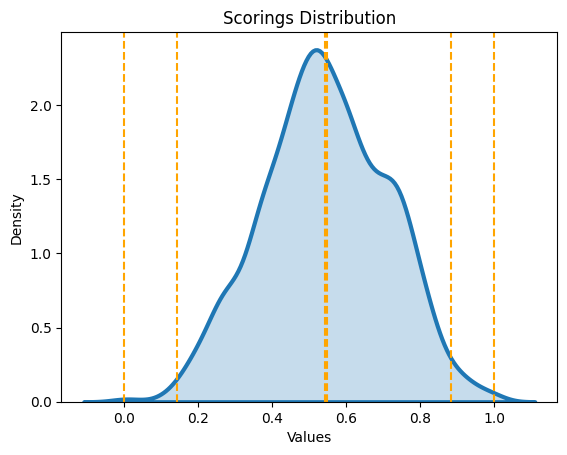

In [7]:
valores = [min(lmin),min(mean),np.median(median),np.mean(mean),max(mean), max(lmax)]
sns.kdeplot(l_scores, fill=True, common_norm=False, linewidth=3)
for valor in valores:
    plt.axvline(x=valor, color='orange', linestyle='--')

plt.title('Scorings Distribution')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show();

## 1.4 Model Preparation

In [8]:
id_estaciones={}
i=1
for dic in estaciones:
    dic['Station_ID']=i
    id_estaciones[dic['address']]=i
    i+=1

In [9]:
capacities={}
for i in estaciones:
    capacities[i['Station_ID']]=i['capacity']
distancia_estaciones_barrios={}
for est,dic in dist_est_barrios.items():
    dicsort = dict(sorted(dic.items(), key=lambda item: item[1]))
    dist_est_barrios[est]=dicsort

mas_cercanos={}
for k,v in dist_est_barrios.items():
    mas_cercanos[k]=list(v.keys())[:1]
mas_cercanos
barrio_distrito={}
for dic in barrios:
    barrio_distrito[dic['nta']]=dic['boro_name']

In [10]:
response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/located_firehouses.json")
json_response = json.loads(response.text)

coordenadas=[]
for dic in (json_response['features']):
    info={}
    info['Name']=dic['properties']['FacilityAddress']
    info['ID']=int(dic['id'])+1
    info['Lat']=dic['geometry']['coordinates'][1]
    info['Lon']=dic['geometry']['coordinates'][0]
    coordenadas.append(info)
for c in coordenadas:
    c['Barrio']=mas_cercanos[c['Name']][0]
for c in coordenadas:
    c['Distrito']=barrio_distrito[c['Barrio']]
coordenadas

[{'Name': '42 South Street',
  'ID': 1,
  'Lat': 40.703694,
  'Lon': -74.007717,
  'Barrio': 'MN25',
  'Distrito': 'Manhattan'},
 {'Name': '49 Beekman Street',
  'ID': 2,
  'Lat': 40.709971,
  'Lon': -74.005395,
  'Barrio': 'MN24',
  'Distrito': 'Manhattan'},
 {'Name': '100 Duane Street',
  'ID': 3,
  'Lat': 40.715339,
  'Lon': -74.0063,
  'Barrio': 'MN24',
  'Distrito': 'Manhattan'},
 {'Name': '14 N. Moore Street',
  'ID': 4,
  'Lat': 40.719574,
  'Lon': -74.00662,
  'Barrio': 'MN24',
  'Distrito': 'Manhattan'},
 {'Name': '75 Canal Street',
  'ID': 5,
  'Lat': 40.715408,
  'Lon': -73.992834,
  'Barrio': 'MN27',
  'Distrito': 'Manhattan'},
 {'Name': '25 Pitt Street',
  'ID': 6,
  'Lat': 40.716439,
  'Lon': -73.983927,
  'Barrio': 'MN28',
  'Distrito': 'Manhattan'},
 {'Name': '222 East 2 Street',
  'ID': 7,
  'Lat': 40.721879,
  'Lon': -73.982526,
  'Barrio': 'MN28',
  'Distrito': 'Manhattan'},
 {'Name': '340 East 14 Street',
  'ID': 8,
  'Lat': 40.731494,
  'Lon': -73.983407,
  'Barrio

In [11]:
dist_est2={}
for estacion,distancias in dist_est.items():
    dist_est2[id_estaciones[estacion]]=distancias

dic_distancias={}
for estacion,dic in dist_est2.items():
    dics2={}
    for k,v in dic.items():
        dics2[id_estaciones[k]]=v
    dic_distancias[estacion]=dics2
distancias_dic={(ext, k_int): v_int for ext, int_dict in dic_distancias.items() for k_int, v_int in int_dict.items()}
distancias_dic

{(1, 2): 154.94,
 (1, 3): 299.43,
 (1, 4): 408.12,
 (1, 5): 296.75,
 (1, 6): 392.35,
 (1, 7): 505.01,
 (1, 8): 600.54,
 (1, 9): 408.56,
 (1, 10): 494.1,
 (1, 11): 609.1,
 (1, 12): 654.99,
 (1, 13): 879.21,
 (1, 14): 841.05,
 (1, 15): 759.44,
 (1, 16): 841.22,
 (1, 17): 771.14,
 (1, 18): 731.46,
 (1, 19): 773.22,
 (1, 20): 899.85,
 (1, 21): 967.4,
 (1, 22): 1059.49,
 (1, 23): 1151.78,
 (1, 24): 1236.84,
 (1, 25): 763.81,
 (1, 26): 975.39,
 (1, 27): 1001.09,
 (1, 28): 1248.45,
 (1, 29): 1091.13,
 (1, 30): 1204.23,
 (1, 31): 1289.21,
 (1, 32): 1348.47,
 (1, 33): 1393.09,
 (1, 34): 1362.0,
 (1, 35): 1441.98,
 (1, 36): 1606.89,
 (1, 37): 1661.13,
 (1, 38): 366.57,
 (1, 39): 948.64,
 (1, 40): 866.7,
 (1, 41): 1479.4,
 (1, 42): 1496.46,
 (1, 43): 1536.17,
 (1, 44): 175.02,
 (1, 45): 831.43,
 (1, 46): 517.35,
 (1, 47): 1598.08,
 (1, 48): 699.88,
 (1, 49): 1377.38,
 (1, 50): 1507.81,
 (1, 51): 1551.37,
 (1, 52): 1656.6,
 (1, 53): 1534.05,
 (1, 54): 1331.22,
 (1, 55): 1607.31,
 (1, 56): 1773.81,

# 2. Solving the integer linear programming scenario

### 2.1. Libraries to import

In [12]:
!pip install ortools
from ortools.linear_solver import pywraplp
import folium

### 2.2. Creating the solver instance

In [13]:
solver = pywraplp.Solver.CreateSolver("CBC")

### 2.3. Creating the decision variables

In [14]:
types_vehicles=5
number_stations=len(estaciones)
turnos=2
ubicaciones = {}
cambios={}

for i in range(types_vehicles):
    for j in range(number_stations):
        for k in range(turnos):
            v = solver.BoolVar(f'Vehicle of type {i+1} assigned at station {j+1} at shift {k+1}')
            ubicaciones[(i+1,j+1,k+1)] = v
for i in range(types_vehicles):
    for j in range(number_stations):
        for k in range(number_stations):
            if j!=k:
                v = solver.BoolVar(f'Vehicle of type {i+1} moves from station {j+1} to station {k+1}')
                cambios[(i+1,j+1,k+1)] = v

### 2.4. Creating the objective function

In [15]:
objective = solver.Objective()
objective.SetMaximization()
for i in range(types_vehicles):
    for j in range(number_stations):
        for k in range(turnos):
            v = ubicaciones[(i+1,j+1,k+1)]
            score = scores[(i+1,j+1,k+1)]
            objective.SetCoefficient(v, score)
for i in range(types_vehicles):
    for j in range(number_stations):
        for k in range(number_stations):
            if j!=k:
                c = cambios[(i+1,j+1,k+1)]
                score = 0
                objective.SetCoefficient(c, score)

### 2.5. Creating the constraints
#### The total number of vehicles assigned in a station should be a minimum of one and a maximum of the station's capacity.

In [16]:
capacity_constraints=[]
for i in range(number_stations):
    for k in range(turnos):
        cap=capacities[i+1]
        c = solver.Constraint(1, cap)
        for j in range(types_vehicles):
            u=ubicaciones[(j+1,i+1,k+1)]
            c.SetCoefficient(u, 1)
        capacity_constraints.append(c)

#### The number of allocated vehicles of each type must be exactly the number of available vehicles of each type.

In [17]:
number_vehicles={1:197,2:143,3:5,4:8,5:1}
vehicle_shift_constraints=[]
for i in range(types_vehicles):
    for k in range(turnos):
        c = solver.Constraint(number_vehicles[i+1], number_vehicles[i+1])
        for j in range(number_stations):
            u=ubicaciones[(i+1,j+1,k+1)]
            c.SetCoefficient(u, 1)
        vehicle_shift_constraints.append(c)

#### A vehicle of a type cannot leave if it is not in the station on turn 1, if there was one, only one vehicle of each station can move.

In [18]:
exit_constraints=[]
for i in range(types_vehicles):
    for j in range(number_stations):
        c = solver.Constraint(-solver.infinity(),0)
        ubi=ubicaciones[(i+1,j+1,1)]
        c.SetCoefficient(ubi,-1)
        for k in range(number_stations):
            if k!=j:
                cmb=cambios[(i+1,j+1,k+1)]
                c.SetCoefficient(cmb, 1)
        exit_constraints.append(c)

#### A vehicle of one type cannot arrive if it was already there on shift 1, if it was not there, a maximum of one of that type can arrive.

In [19]:
arrive_constraints=[]
for i in range(types_vehicles):
    for k in range(number_stations):
        c=solver.Constraint(-solver.infinity(),1)
        ubi=ubicaciones[(i+1,k+1,1)]
        c.SetCoefficient(ubi,1)
        for j in range(number_stations):
            if j!=k:
                cam=cambios[(i+1,j+1,k+1)]
                c.SetCoefficient(cam,1)
        arrive_constraints.append(c)

#### Shift 2 = Shift 1 - exits + entrances

In [20]:
constraints=[]
for i in range(types_vehicles):
    for j in range(number_stations):
        c=solver.Constraint(0,0)
        turno2=ubicaciones[(i+1,j+1,2)]
        turno1=ubicaciones[(i+1,j+1,1)]
        c.SetCoefficient(turno2,1)
        c.SetCoefficient(turno1,-1)
        for k in range(number_stations):
            if k!=j:
                salidas=cambios[(i+1,j+1,k+1)]
                c.SetCoefficient(salidas,1)
                entradas=cambios[(i+1,k+1,j+1)]
                c.SetCoefficient(entradas,-1)
        constraints.append(c)

#### No more than two type 3 vehicles may be in the same borough.

In [21]:
manhattan=[]
for estacion in coordenadas:
    if estacion['Distrito']=='Manhattan':
        manhattan.append(estacion['ID'])
for k in range(turnos):
    c=solver.Constraint(0,2)
    for j in range(number_stations):
        if j+1 in manhattan:
            v=ubicaciones[(3,j+1,k+1)]
            c.SetCoefficient(v,1)
bronx=[]
for estacion in coordenadas:
    if estacion['Distrito']=='Bronx':
        bronx.append(estacion['ID'])
for k in range(turnos):
    c=solver.Constraint(0,2)
    for j in range(number_stations):
        if j+1 in bronx:
            v=ubicaciones[(3,j+1,k+1)]
            c.SetCoefficient(v,1)
Brooklyn=[]
for estacion in coordenadas:
    if estacion['Distrito']=='Brooklyn':
        Brooklyn.append(estacion['ID'])
for k in range(turnos):
    c=solver.Constraint(0,2)
    for j in range(number_stations):
        if j+1 in Brooklyn:
            v=ubicaciones[(3,j+1,k+1)]
            c.SetCoefficient(v,1)
Queens=[]
for estacion in coordenadas:
    if estacion['Distrito']=='Queens':
        Queens.append(estacion['ID'])
for k in range(turnos):
    c=solver.Constraint(0,2)
    for j in range(number_stations):
        if j+1 in Queens:
            v=ubicaciones[(3,j+1,k+1)]
            c.SetCoefficient(v,1)
Staten_Island=[]
for estacion in coordenadas:
    if estacion['Distrito']=='Staten Island':
        Staten_Island.append(estacion['ID'])
for k in range(turnos):
    c=solver.Constraint(0,2)
    for j in range(number_stations):
        if j+1 in Staten_Island:
            v=ubicaciones[(3,j+1,k+1)]
            c.SetCoefficient(v,1)

#### There may be a maximum of three type 4 vehicles in each borough and at least one in each borough.

In [22]:
for k in range(turnos):
    c=solver.Constraint(1,3)
    for j in range(number_stations):
        if j+1 in manhattan:
            v=ubicaciones[(4,j+1,k+1)]
            c.SetCoefficient(v,1)
for k in range(turnos):
    c=solver.Constraint(1,3)
    for j in range(number_stations):
        if j+1 in bronx:
            v=ubicaciones[(4,j+1,k+1)]
            c.SetCoefficient(v,1)

for k in range(turnos):
    c=solver.Constraint(1,3)
    for j in range(number_stations):
        if j+1 in Brooklyn:
            v=ubicaciones[(4,j+1,k+1)]
            c.SetCoefficient(v,1)

for k in range(turnos):
    c=solver.Constraint(1,3)
    for j in range(number_stations):
        if j+1 in Queens:
            v=ubicaciones[(4,j+1,k+1)]
            c.SetCoefficient(v,1)
for k in range(turnos):
    c=solver.Constraint(1,3)
    for j in range(number_stations):
        if j+1 in Staten_Island:
            v=ubicaciones[(4,j+1,k+1)]
            c.SetCoefficient(v,1)

#### The movements cannot be further apart at a distance of 780 seconds.

In [23]:
for i in range(types_vehicles):
    for j in range(number_stations):
        for k in range(number_stations):
            if j!=k:
                c=solver.Constraint(0,780)
                v=cambios[(i+1,j+1,k+1)]
                c.SetCoefficient(v,distancias_dic[(j+1,k+1)])

### 2.6. Solution obtained

In [24]:
stations_1_1=[]
stations_1_2=[]
stations_2_1=[]
stations_2_2=[]
stations_3_1=[]
stations_3_2=[]
stations_4_1=[]
stations_4_2=[]
stations_5_1=[]
stations_5_2=[]

result = solver.Solve()
if result == solver.OPTIMAL :
    print("In the specified time limit the solver has found a feasible solution")
    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(turnos):
                v = ubicaciones[(i+1,j+1,k+1)]

                if v.SolutionValue()>0.1:
                    if i+1==1 and k+1==1:
                        stations_1_1.append(j+1)
                    if i+1==1 and k+1==2:
                        stations_1_2.append(j+1)
                    if i+1==2 and k+1==1:
                        stations_2_1.append(j+1)
                    if i+1==2 and k+1==2:
                        stations_2_2.append(j+1)
                    if i+1==3 and k+1==1:
                        stations_3_1.append(j+1)
                    if i+1==3 and k+1==2:
                        stations_3_2.append(j+1)
                    if i+1==4 and k+1==1:
                        stations_4_1.append(j+1)
                    if i+1==4 and k+1==2:
                        stations_4_2.append(j+1)
                    if i+1==5 and k+1==1:
                        stations_5_1.append(j+1)
                    if i+1==5 and k+1==2:
                        stations_5_2.append(j+1)

                    print(v, (v.solution_value()))
    print('----------------------')
    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(number_stations):
                if j!=k:
                    c = cambios[(i+1,j+1,k+1)]
                    if c.SolutionValue()>0.1:
                        print(c, (c.solution_value()))

crd={(1,1):stations_1_1,(1,2):stations_1_2,(2,1):stations_2_1,(2,2):stations_2_2,(3,1):stations_3_1,(3,2):stations_3_2,(4,1):stations_4_1,(4,2):stations_4_2,(5,1):stations_5_1,(5,2):stations_5_2}

In the specified time limit the solver has found a feasible solution
Vehicle of type 1 assigned at station 1 at shift 1 1.0
Vehicle of type 1 assigned at station 1 at shift 2 1.0
Vehicle of type 1 assigned at station 2 at shift 2 1.0
Vehicle of type 1 assigned at station 3 at shift 2 1.0
Vehicle of type 1 assigned at station 4 at shift 1 1.0
Vehicle of type 1 assigned at station 4 at shift 2 1.0
Vehicle of type 1 assigned at station 5 at shift 1 1.0
Vehicle of type 1 assigned at station 5 at shift 2 1.0
Vehicle of type 1 assigned at station 6 at shift 2 1.0
Vehicle of type 1 assigned at station 7 at shift 1 1.0
Vehicle of type 1 assigned at station 7 at shift 2 1.0
Vehicle of type 1 assigned at station 8 at shift 2 1.0
Vehicle of type 1 assigned at station 9 at shift 1 1.0
Vehicle of type 1 assigned at station 9 at shift 2 1.0
Vehicle of type 1 assigned at station 10 at shift 1 1.0
Vehicle of type 1 assigned at station 10 at shift 2 1.0
Vehicle of type 1 assigned at station 11 at shift

### 2.7. Visualising with a map the location of the vehicles in each shift

In [25]:
def mostrarmapa(v,t):# x es el tipo de vehiculo/ t es el turno
    mapa = folium.Map(location=[40.70, -73.94], zoom_start=10, width="50%", tiles="CartoDB positron")
    for est in crd[(v,t)]:
        lat=0
        lon=0
        for estacion in coordenadas:
            if estacion['ID']==est:
                lat+=estacion['Lat']
                lon+=estacion['Lon']
            folium.Circle(location=(lat,lon), radius=250, color='blue', fill=True, fill_color='red',fill_opacity=1).add_to(mapa)
    return mapa

In [1]:
#mostrarmapa(1,1)

# 3. Experimentation

## 3.1. Libraries to import

In [35]:
from ortools.linear_solver import pywraplp
from numpy import average, std
from time import time
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind

## 3.2. Testing different solvers

In [29]:
solvers_avg_time = [] #A list including the average time it takes each solver to find a solution to the problem

#### SCIP solver

In [30]:
scip_times = [] #A list including the 50 resolution times of the SCIP solver
for i in range(50):
    #The next code snippet is the creation of the solver, variables, etc.,
    #things that have been done before but need to be repeated to evaluate the performance of each solver
    #So you can skip reading the following code snippet until you see a dashed line

    #Creating the solver object
    solver = pywraplp.Solver.CreateSolver("SCIP")

    #Creating the decision variables
    types_vehicles=5
    number_stations=len(estaciones)
    turnos=2
    ubicaciones = {}
    cambios={}

    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(turnos):
                v = solver.BoolVar(f'Vehicle of type {i+1} assigned at station {j+1} at shift {k+1}')
                ubicaciones[(i+1,j+1,k+1)] = v
    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(number_stations):
                if j!=k:
                    v = solver.BoolVar(f'Vehicle of type {i+1} moves from station {j+1} to station {k+1}')
                    cambios[(i+1,j+1,k+1)] = v

    #Creating the objective function
    objective = solver.Objective()
    objective.SetMaximization()
    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(turnos):
                v = ubicaciones[(i+1,j+1,k+1)]
                score = scores[(i+1,j+1,k+1)]
                objective.SetCoefficient(v, score)
    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(number_stations):
                if j!=k:
                    c = cambios[(i+1,j+1,k+1)]
                    score = 0
                    objective.SetCoefficient(c, score)

    #Creating the constraints
    #1st contraint
    capacity_constraints=[]
    for i in range(number_stations):
        for k in range(turnos):
            cap=capacities[i+1]
            c = solver.Constraint(1, cap)
            for j in range(types_vehicles):
                u=ubicaciones[(j+1,i+1,k+1)]
                c.SetCoefficient(u, 1)
            capacity_constraints.append(c)
    #2nd constraint
    number_vehicles={1:197,2:143,3:5,4:8,5:1}
    vehicle_shift_constraints=[]
    for i in range(types_vehicles):
        for k in range(turnos):
            c = solver.Constraint(number_vehicles[i+1], number_vehicles[i+1])
            for j in range(number_stations):
                u=ubicaciones[(i+1,j+1,k+1)]
                c.SetCoefficient(u, 1)
            vehicle_shift_constraints.append(c)
    #3rd constraint
    exit_constraints=[]
    for i in range(types_vehicles):
        for j in range(number_stations):
            c = solver.Constraint(-solver.infinity(),0)
            ubi=ubicaciones[(i+1,j+1,1)]
            c.SetCoefficient(ubi,-1)
            for k in range(number_stations):
                if k!=j:
                    cmb=cambios[(i+1,j+1,k+1)]
                    c.SetCoefficient(cmb, 1)
            exit_constraints.append(c)
    #4th constraint
    arrive_constraints=[]
    for i in range(types_vehicles):
        for k in range(number_stations):
            c=solver.Constraint(-solver.infinity(),1)
            ubi=ubicaciones[(i+1,k+1,1)]
            c.SetCoefficient(ubi,1)
            for j in range(number_stations):
                if j!=k:
                    cam=cambios[(i+1,j+1,k+1)]
                    c.SetCoefficient(cam,1)
            arrive_constraints.append(c)
    #5th constraint
    constraints=[]
    for i in range(types_vehicles):
        for j in range(number_stations):
            c=solver.Constraint(0,0)
            turno2=ubicaciones[(i+1,j+1,2)]
            turno1=ubicaciones[(i+1,j+1,1)]
            c.SetCoefficient(turno2,1)
            c.SetCoefficient(turno1,-1)
            for k in range(number_stations):
                if k!=j:
                    salidas=cambios[(i+1,j+1,k+1)]
                    c.SetCoefficient(salidas,1)
                    entradas=cambios[(i+1,k+1,j+1)]
                    c.SetCoefficient(entradas,-1)
            constraints.append(c)
    #6th constraint
    manhattan=[]
    for estacion in coordenadas:
        if estacion['Distrito']=='Manhattan':
            manhattan.append(estacion['ID'])
    for k in range(turnos):
        c=solver.Constraint(0,2)
        for j in range(number_stations):
            if j+1 in manhattan:
                v=ubicaciones[(3,j+1,k+1)]
                c.SetCoefficient(v,1)
    bronx=[]
    for estacion in coordenadas:
        if estacion['Distrito']=='Bronx':
            bronx.append(estacion['ID'])
    for k in range(turnos):
        c=solver.Constraint(0,2)
        for j in range(number_stations):
            if j+1 in bronx:
                v=ubicaciones[(3,j+1,k+1)]
                c.SetCoefficient(v,1)
    Brooklyn=[]
    for estacion in coordenadas:
        if estacion['Distrito']=='Brooklyn':
            Brooklyn.append(estacion['ID'])
    for k in range(turnos):
        c=solver.Constraint(0,2)
        for j in range(number_stations):
            if j+1 in Brooklyn:
                v=ubicaciones[(3,j+1,k+1)]
                c.SetCoefficient(v,1)
    Queens=[]
    for estacion in coordenadas:
        if estacion['Distrito']=='Queens':
            Queens.append(estacion['ID'])
    for k in range(turnos):
        c=solver.Constraint(0,2)
        for j in range(number_stations):
            if j+1 in Queens:
                v=ubicaciones[(3,j+1,k+1)]
                c.SetCoefficient(v,1)
    Staten_Island=[]
    for estacion in coordenadas:
        if estacion['Distrito']=='Staten Island':
            Staten_Island.append(estacion['ID'])
    for k in range(turnos):
        c=solver.Constraint(0,2)
        for j in range(number_stations):
            if j+1 in Staten_Island:
                v=ubicaciones[(3,j+1,k+1)]
                c.SetCoefficient(v,1)
    #7th constraint
    for k in range(turnos):
        c=solver.Constraint(1,3)
        for j in range(number_stations):
            if j+1 in manhattan:
                v=ubicaciones[(4,j+1,k+1)]
                c.SetCoefficient(v,1)
    for k in range(turnos):
        c=solver.Constraint(1,3)
        for j in range(number_stations):
            if j+1 in bronx:
                v=ubicaciones[(4,j+1,k+1)]
                c.SetCoefficient(v,1)

    for k in range(turnos):
        c=solver.Constraint(1,3)
        for j in range(number_stations):
            if j+1 in Brooklyn:
                v=ubicaciones[(4,j+1,k+1)]
                c.SetCoefficient(v,1)

    for k in range(turnos):
        c=solver.Constraint(1,3)
        for j in range(number_stations):
            if j+1 in Queens:
                v=ubicaciones[(4,j+1,k+1)]
                c.SetCoefficient(v,1)
    for k in range(turnos):
        c=solver.Constraint(1,3)
        for j in range(number_stations):
            if j+1 in Staten_Island:
                v=ubicaciones[(4,j+1,k+1)]
                c.SetCoefficient(v,1)
    #8th constraint
    for i in range(types_vehicles):
      for j in range(number_stations):
          for k in range(number_stations):
              if j!=k:
                  c=solver.Constraint(0,780)
                  v=cambios[(i+1,j+1,k+1)]
                  c.SetCoefficient(v,distancias_dic[(j+1,k+1)])

    #------------------------------

    #We evaluate the performance of the solver from here onwards
    #Initialising time
    t1 = time()

    #Getting the solution
    result = solver.Solve()

    #Ending time
    total_time = time() - t1

    #Adding the time taken by the solver to find a solution to the list "scip_times"
    scip_times.append(total_time)

solvers_avg_time.append(average(scip_times)) #Adding the average of the SCIP solver
#resolution times to the "solvers_avg_time" list

#### CBC solver

In [31]:
cbc_times = [] #A list including the 50 resolution times of the CBC solver
for i in range(50):
    #The next code snippet is the creation of the solver, variables, etc.,
    # things that have been done before but need to be repeated to evaluate the performance of each solver
    #So you can skip reading the following code snippet until you see a dashed line

    #Creating the solver object
    solver = pywraplp.Solver.CreateSolver("CBC")

    #Creating the decision variables
    types_vehicles=5
    number_stations=len(estaciones)
    turnos=2
    ubicaciones = {}
    cambios={}

    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(turnos):
                v = solver.BoolVar(f'Vehicle of type {i+1} assigned at station {j+1} at shift {k+1}')
                ubicaciones[(i+1,j+1,k+1)] = v
    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(number_stations):
                if j!=k:
                    v = solver.BoolVar(f'Vehicle of type {i+1} moves from station {j+1} to station {k+1}')
                    cambios[(i+1,j+1,k+1)] = v

    #Creating the objective function
    objective = solver.Objective()
    objective.SetMaximization()
    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(turnos):
                v = ubicaciones[(i+1,j+1,k+1)]
                score = scores[(i+1,j+1,k+1)]
                objective.SetCoefficient(v, score)
    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(number_stations):
                if j!=k:
                    c = cambios[(i+1,j+1,k+1)]
                    score = 0
                    objective.SetCoefficient(c, score)

    #Creating the constraints
    #1st contraint
    capacity_constraints=[]
    for i in range(number_stations):
        for k in range(turnos):
            cap=capacities[i+1]
            c = solver.Constraint(1, cap)
            for j in range(types_vehicles):
                u=ubicaciones[(j+1,i+1,k+1)]
                c.SetCoefficient(u, 1)
            capacity_constraints.append(c)
    #2nd constraint
    number_vehicles={1:197,2:143,3:5,4:8,5:1}
    vehicle_shift_constraints=[]
    for i in range(types_vehicles):
        for k in range(turnos):
            c = solver.Constraint(number_vehicles[i+1], number_vehicles[i+1])
            for j in range(number_stations):
                u=ubicaciones[(i+1,j+1,k+1)]
                c.SetCoefficient(u, 1)
            vehicle_shift_constraints.append(c)
    #3rd constraint
    exit_constraints=[]
    for i in range(types_vehicles):
        for j in range(number_stations):
            c = solver.Constraint(-solver.infinity(),0)
            ubi=ubicaciones[(i+1,j+1,1)]
            c.SetCoefficient(ubi,-1)
            for k in range(number_stations):
                if k!=j:
                    cmb=cambios[(i+1,j+1,k+1)]
                    c.SetCoefficient(cmb, 1)
            exit_constraints.append(c)
    #4th constraint
    arrive_constraints=[]
    for i in range(types_vehicles):
        for k in range(number_stations):
            c=solver.Constraint(-solver.infinity(),1)
            ubi=ubicaciones[(i+1,k+1,1)]
            c.SetCoefficient(ubi,1)
            for j in range(number_stations):
                if j!=k:
                    cam=cambios[(i+1,j+1,k+1)]
                    c.SetCoefficient(cam,1)
            arrive_constraints.append(c)
    #5th constraint
    constraints=[]
    for i in range(types_vehicles):
        for j in range(number_stations):
            c=solver.Constraint(0,0)
            turno2=ubicaciones[(i+1,j+1,2)]
            turno1=ubicaciones[(i+1,j+1,1)]
            c.SetCoefficient(turno2,1)
            c.SetCoefficient(turno1,-1)
            for k in range(number_stations):
                if k!=j:
                    salidas=cambios[(i+1,j+1,k+1)]
                    c.SetCoefficient(salidas,1)
                    entradas=cambios[(i+1,k+1,j+1)]
                    c.SetCoefficient(entradas,-1)
            constraints.append(c)
    #6th constraint
    manhattan=[]
    for estacion in coordenadas:
        if estacion['Distrito']=='Manhattan':
            manhattan.append(estacion['ID'])
    for k in range(turnos):
        c=solver.Constraint(0,2)
        for j in range(number_stations):
            if j+1 in manhattan:
                v=ubicaciones[(3,j+1,k+1)]
                c.SetCoefficient(v,1)
    bronx=[]
    for estacion in coordenadas:
        if estacion['Distrito']=='Bronx':
            bronx.append(estacion['ID'])
    for k in range(turnos):
        c=solver.Constraint(0,2)
        for j in range(number_stations):
            if j+1 in bronx:
                v=ubicaciones[(3,j+1,k+1)]
                c.SetCoefficient(v,1)
    Brooklyn=[]
    for estacion in coordenadas:
        if estacion['Distrito']=='Brooklyn':
            Brooklyn.append(estacion['ID'])
    for k in range(turnos):
        c=solver.Constraint(0,2)
        for j in range(number_stations):
            if j+1 in Brooklyn:
                v=ubicaciones[(3,j+1,k+1)]
                c.SetCoefficient(v,1)
    Queens=[]
    for estacion in coordenadas:
        if estacion['Distrito']=='Queens':
            Queens.append(estacion['ID'])
    for k in range(turnos):
        c=solver.Constraint(0,2)
        for j in range(number_stations):
            if j+1 in Queens:
                v=ubicaciones[(3,j+1,k+1)]
                c.SetCoefficient(v,1)
    Staten_Island=[]
    for estacion in coordenadas:
        if estacion['Distrito']=='Staten Island':
            Staten_Island.append(estacion['ID'])
    for k in range(turnos):
        c=solver.Constraint(0,2)
        for j in range(number_stations):
            if j+1 in Staten_Island:
                v=ubicaciones[(3,j+1,k+1)]
                c.SetCoefficient(v,1)
    #7th constraint
    for k in range(turnos):
        c=solver.Constraint(1,3)
        for j in range(number_stations):
            if j+1 in manhattan:
                v=ubicaciones[(4,j+1,k+1)]
                c.SetCoefficient(v,1)
    for k in range(turnos):
        c=solver.Constraint(1,3)
        for j in range(number_stations):
            if j+1 in bronx:
                v=ubicaciones[(4,j+1,k+1)]
                c.SetCoefficient(v,1)

    for k in range(turnos):
        c=solver.Constraint(1,3)
        for j in range(number_stations):
            if j+1 in Brooklyn:
                v=ubicaciones[(4,j+1,k+1)]
                c.SetCoefficient(v,1)

    for k in range(turnos):
        c=solver.Constraint(1,3)
        for j in range(number_stations):
            if j+1 in Queens:
                v=ubicaciones[(4,j+1,k+1)]
                c.SetCoefficient(v,1)
    for k in range(turnos):
        c=solver.Constraint(1,3)
        for j in range(number_stations):
            if j+1 in Staten_Island:
                v=ubicaciones[(4,j+1,k+1)]
                c.SetCoefficient(v,1)
    #8th constraint
    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(number_stations):
                if j!=k:
                    if distancias_dic[(j+1,k+1)]>780:
                        c=solver.Constraint(0,0)
                        v=cambios[(i+1,j+1,k+1)]
                        c.SetCoefficient(v,1)

    #------------------------------

    #We evaluate the performance of the solver from here onwards
    #Initialising time
    t1 = time()

    #Getting the solution
    result = solver.Solve()

    #Ending time
    total_time = time() - t1

    #Adding the time taken by the solver to find a solution to the list "cbc_times"
    cbc_times.append(total_time)

solvers_avg_time.append(average(cbc_times)) #Adding the average of the CBC solver
#resolution times to the "solvers_avg_time" list

#### BOP solver

In [34]:
bop_times = [] #A list including the 50 resolution times of the BOP solver
for i in range(50):
    #The next code snippet is the creation of the solver, variables, etc.,
    # things that have been done before but need to be repeated to evaluate the performance of each solver
    #So you can skip reading the following code snippet until you see a dashed line

    #Creating the solver object
    solver = pywraplp.Solver.CreateSolver("BOP")

    #Creating the decision variables
    types_vehicles=5
    number_stations=len(estaciones)
    turnos=2
    ubicaciones = {}
    cambios={}

    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(turnos):
                v = solver.BoolVar(f'Vehicle of type {i+1} assigned at station {j+1} at shift {k+1}')
                ubicaciones[(i+1,j+1,k+1)] = v
    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(number_stations):
                if j!=k:
                    v = solver.BoolVar(f'Vehicle of type {i+1} moves from station {j+1} to station {k+1}')
                    cambios[(i+1,j+1,k+1)] = v

    #Creating the objective function
    objective = solver.Objective()
    objective.SetMaximization()
    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(turnos):
                v = ubicaciones[(i+1,j+1,k+1)]
                score = scores[(i+1,j+1,k+1)]
                objective.SetCoefficient(v, score)
    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(number_stations):
                if j!=k:
                    c = cambios[(i+1,j+1,k+1)]
                    score = 0
                    objective.SetCoefficient(c, score)

    #Creating the constraints
    #1st contraint
    capacity_constraints=[]
    for i in range(number_stations):
        for k in range(turnos):
            cap=capacities[i+1]
            c = solver.Constraint(1, cap)
            for j in range(types_vehicles):
                u=ubicaciones[(j+1,i+1,k+1)]
                c.SetCoefficient(u, 1)
            capacity_constraints.append(c)
    #2nd constraint
    number_vehicles={1:197,2:143,3:5,4:8,5:1}
    vehicle_shift_constraints=[]
    for i in range(types_vehicles):
        for k in range(turnos):
            c = solver.Constraint(number_vehicles[i+1], number_vehicles[i+1])
            for j in range(number_stations):
                u=ubicaciones[(i+1,j+1,k+1)]
                c.SetCoefficient(u, 1)
            vehicle_shift_constraints.append(c)
    #3rd constraint
    exit_constraints=[]
    for i in range(types_vehicles):
        for j in range(number_stations):
            c = solver.Constraint(-solver.infinity(),0)
            ubi=ubicaciones[(i+1,j+1,1)]
            c.SetCoefficient(ubi,-1)
            for k in range(number_stations):
                if k!=j:
                    cmb=cambios[(i+1,j+1,k+1)]
                    c.SetCoefficient(cmb, 1)
            exit_constraints.append(c)
    #4th constraint
    arrive_constraints=[]
    for i in range(types_vehicles):
        for k in range(number_stations):
            c=solver.Constraint(-solver.infinity(),1)
            ubi=ubicaciones[(i+1,k+1,1)]
            c.SetCoefficient(ubi,1)
            for j in range(number_stations):
                if j!=k:
                    cam=cambios[(i+1,j+1,k+1)]
                    c.SetCoefficient(cam,1)
            arrive_constraints.append(c)
    #5th constraint
    constraints=[]
    for i in range(types_vehicles):
        for j in range(number_stations):
            c=solver.Constraint(0,0)
            turno2=ubicaciones[(i+1,j+1,2)]
            turno1=ubicaciones[(i+1,j+1,1)]
            c.SetCoefficient(turno2,1)
            c.SetCoefficient(turno1,-1)
            for k in range(number_stations):
                if k!=j:
                    salidas=cambios[(i+1,j+1,k+1)]
                    c.SetCoefficient(salidas,1)
                    entradas=cambios[(i+1,k+1,j+1)]
                    c.SetCoefficient(entradas,-1)
            constraints.append(c)
    #6th constraint
    manhattan=[]
    for estacion in coordenadas:
        if estacion['Distrito']=='Manhattan':
            manhattan.append(estacion['ID'])
    for k in range(turnos):
        c=solver.Constraint(0,2)
        for j in range(number_stations):
            if j+1 in manhattan:
                v=ubicaciones[(3,j+1,k+1)]
                c.SetCoefficient(v,1)
    bronx=[]
    for estacion in coordenadas:
        if estacion['Distrito']=='Bronx':
            bronx.append(estacion['ID'])
    for k in range(turnos):
        c=solver.Constraint(0,2)
        for j in range(number_stations):
            if j+1 in bronx:
                v=ubicaciones[(3,j+1,k+1)]
                c.SetCoefficient(v,1)
    Brooklyn=[]
    for estacion in coordenadas:
        if estacion['Distrito']=='Brooklyn':
            Brooklyn.append(estacion['ID'])
    for k in range(turnos):
        c=solver.Constraint(0,2)
        for j in range(number_stations):
            if j+1 in Brooklyn:
                v=ubicaciones[(3,j+1,k+1)]
                c.SetCoefficient(v,1)
    Queens=[]
    for estacion in coordenadas:
        if estacion['Distrito']=='Queens':
            Queens.append(estacion['ID'])
    for k in range(turnos):
        c=solver.Constraint(0,2)
        for j in range(number_stations):
            if j+1 in Queens:
                v=ubicaciones[(3,j+1,k+1)]
                c.SetCoefficient(v,1)
    Staten_Island=[]
    for estacion in coordenadas:
        if estacion['Distrito']=='Staten Island':
            Staten_Island.append(estacion['ID'])
    for k in range(turnos):
        c=solver.Constraint(0,2)
        for j in range(number_stations):
            if j+1 in Staten_Island:
                v=ubicaciones[(3,j+1,k+1)]
                c.SetCoefficient(v,1)
    #7th constraint
    for k in range(turnos):
        c=solver.Constraint(1,3)
        for j in range(number_stations):
            if j+1 in manhattan:
                v=ubicaciones[(4,j+1,k+1)]
                c.SetCoefficient(v,1)
    for k in range(turnos):
        c=solver.Constraint(1,3)
        for j in range(number_stations):
            if j+1 in bronx:
                v=ubicaciones[(4,j+1,k+1)]
                c.SetCoefficient(v,1)

    for k in range(turnos):
        c=solver.Constraint(1,3)
        for j in range(number_stations):
            if j+1 in Brooklyn:
                v=ubicaciones[(4,j+1,k+1)]
                c.SetCoefficient(v,1)

    for k in range(turnos):
        c=solver.Constraint(1,3)
        for j in range(number_stations):
            if j+1 in Queens:
                v=ubicaciones[(4,j+1,k+1)]
                c.SetCoefficient(v,1)
    for k in range(turnos):
        c=solver.Constraint(1,3)
        for j in range(number_stations):
            if j+1 in Staten_Island:
                v=ubicaciones[(4,j+1,k+1)]
                c.SetCoefficient(v,1)
    #8th constraint
    for i in range(types_vehicles):
        for j in range(number_stations):
            for k in range(number_stations):
                if j!=k:
                    if distancias_dic[(j+1,k+1)]>780:
                        c=solver.Constraint(0,0)
                        v=cambios[(i+1,j+1,k+1)]
                        c.SetCoefficient(v,1)

    #------------------------------

    #We evaluate the performance of the solver from here onwards
    #Initialising time
    t1 = time()

    #Getting the solution
    result = solver.Solve()

    #Ending time
    total_time = time() - t1

    #Adding the time taken by the solver to find a solution to the list "bop_times"
    bop_times.append(total_time)

solvers_avg_time.append(average(bop_times)) #Adding the average of the BOP solver
# resolution times to the "solvers_avg_time" list

#### Bar chart to compare average resolution times of each solver

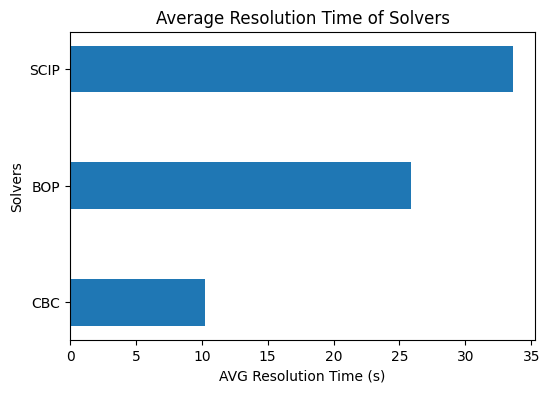

In [49]:
# Data for the bar chart
x = ["SCIP", "CBC", "BOP"]
y = solvers_avg_time

# Sorting the data to make the bars horizontal and ordered from highest to lowest
sorted_indices = sorted(range(len(y)), key=lambda i: y[i], reverse=True)
x_sorted = [x[i] for i in sorted_indices]
y_sorted = [y[i] for i in sorted_indices]

plt.figure(figsize=(6,4))
# Creating the horizontal bar chart with thinner bars
plt.barh(x_sorted, y_sorted, height=0.4)  # Set the bar height to be thinner
plt.title("Average Resolution Time of Solvers")
plt.xlabel("AVG Resolution Time (s)")
plt.ylabel("Solvers")
plt.gca().invert_yaxis()  # Invert y-axis to display the largest bar on top
plt.show();

## 3.3. Statistical Significance Test

#### Normal Distribution? Shapiro-Wilk's test

- $H_{0}$: Solving times obtained with the "x" solver follow a normal distribution (True if p-value >= 0.05)
- $H_{1}$: Solving times obtained with the "x" solver do not follow a normal distribution (True if p-value < 0.05)

In [50]:
samples = {"SCIP": scip_times, "CBC": cbc_times, "BOP": bop_times}
for k,v in samples.items():
    statistic, p_value = shapiro(v)
    if p_value >= 0.05:
        print(f"Solving times obtained with the {k} solver follow a normal distribution (p-value={p_value} >= 0.05)")
    else:
        print(f"Solving times obtained with the {k} solver do not follow a normal distribution (p-value={p_value} < 0.05)")

Solving times obtained with the SCIP solver do not follow a normal distribution (p-value=1.0575324470296632e-11 < 0.05)
Solving times obtained with the CBC solver do not follow a normal distribution (p-value=2.0273903444945063e-08 < 0.05)
Solving times obtained with the BOP solver do not follow a normal distribution (p-value=6.486086334689389e-08 < 0.05)


#### Equality of variances? Levene's test
- $H_{0}$: The respective variances of the solving times obtained with both the "x" solver and the "y" solver are equal (True if p-value > 0.05)
- $H_{1}$: The respective variances of the solving times obtained with both the "x" solver and the "y" solver are not equal (True if p-value <= 0.05)

In [51]:
statistic, p_value = levene(scip_times, cbc_times)
if p_value > 0.05:
    print(f"The respective variances of the solving times obtained with both the SCIP solver and the CBC solver are equal (p-value={p_value} > 0.05)")
else:
    print(f"The respective variances of the solving times obtained with both the SCIP solver and the CBC solver are not equal (p-value={p_value} <= 0.05)")

The respective variances of the solving times obtained with both the SCIP solver and the CBC solver are equal (p-value=0.0889309219265938 > 0.05)


In [52]:
statistic, p_value = levene(scip_times, bop_times)
if p_value > 0.05:
    print(f"The respective variances of the solving times obtained with both the SCIP and the BOP are equal (p-value={p_value} > 0.05)")
else:
    print(f"The respective variances of the solving times obtained with both the SCIP and the BOP are not equal (p-value={p_value} <= 0.05)")

The respective variances of the solving times obtained with both the SCIP and the BOP are not equal (p-value=0.03212106396366459 <= 0.05)


In [53]:
statistic, p_value = levene(cbc_times, bop_times)
if p_value > 0.05:
    print(f"The respective variances of the solving times obtained with both the CBC and the BOP solver are equal (p-value={p_value} > 0.05)")
else:
    print(f"The respective variances of the solving times obtained with both the CBC and the BOP solver are not equal (p-value={p_value} <= 0.05)")

The respective variances of the solving times obtained with both the CBC and the BOP solver are equal (p-value=0.20895030181575774 > 0.05)


#### Differences between the average resolution of each solver? Welch's t-test
- $H_{0}$: The respective averages of the solving times obtained with both the "x" solver and the "y" solver are equal (p-value >= 0.05)
- $H_{1}$: The respective averages of the solving times obtained with both the "x" solver and the "y" solver are not equal (p-value < 0.05)

In [54]:
statistic, p_value = ttest_ind(scip_times, cbc_times, equal_var=False)
if p_value >= 0.05:
    print(f"The respective averages of the solving times obtained with both the SCIP solver and the CBC solver are equal (p-value={p_value} >= 0.05)")
else:
    print(f"The respective averages of the solving times obtained with both the SCIP solver and the CBC solver are not equal (p-value={p_value} < 0.05)")

The respective averages of the solving times obtained with both the SCIP solver and the CBC solver are not equal (p-value=1.0624232936440147e-37 < 0.05)


In [55]:
statistic, p_value = ttest_ind(scip_times, bop_times, equal_var=False)
if p_value >= 0.05:
    print(f"The respective averages of the solving times obtained with both the SCIP solver and the BOP solver are equal (p-value={p_value} >= 0.05)")
else:
    print(f"The respective averages of the solving times obtained with both the SCIP solver and the BOP solver are not equal (p-value={p_value} < 0.05)")

The respective averages of the solving times obtained with both the SCIP solver and the BOP solver are not equal (p-value=9.314042476487485e-37 < 0.05)


In [56]:
statistic, p_value = ttest_ind(cbc_times, bop_times, equal_var=True)
if p_value >= 0.05:
    print(f"The respective averages of the solving times obtained with both the CBC solver and the BOP solver are equal (p-value={p_value} >= 0.05)")
else:
    print(f"The respective averages of the solving times obtained with both the CBC solver and the BOP solver are not equal (p-value={p_value} < 0.05)")

The respective averages of the solving times obtained with both the CBC solver and the BOP solver are not equal (p-value=0.014490002982658928 < 0.05)
